Hãy sử dụng dữ liệu được cung cấp trong email này (dữ liệu giá và khối
lượng của một vài mã cổ phiếu) để xây dựng một số mô hình dự đoán biến
động giá cổ phiếu.

Biến động giá cổ phiếu Δ = Giá cổ phiếu N (phút hoặc giờ hoặc ngày) sau - Giá cổ phiếu hiện tại.

In [1]:
!pip uninstall tensorflow # Fill Y to install latest tf and keras
!pip install tensorflow

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.15.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.15.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# I. XỬ LÝ THEO GIỜ
Ý tưởng: sử dụng dữ liệu delta của 60 phút trước đó để dự đoán delta 20 phút tiếp theo.

In [19]:
# Tương tự thay đổi tên cho các mã khác
csv_dir = "PNJ.csv"
save_model_dir = "PNJ_minute.keras"

## 1. Import dữ liệu (PNJ) và xử lý Pandas

In [4]:
df = pd.read_csv(csv_dir)
df.head(10)

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,PNJ,2/28/2018 9:15,78.14,78.99,78.14,78.99,270,0
1,PNJ,2/28/2018 9:16,78.94,78.94,78.94,78.94,10,0
2,PNJ,2/28/2018 9:19,78.14,78.14,78.14,78.14,283,0
3,PNJ,2/28/2018 9:20,78.14,78.14,78.14,78.14,480,0
4,PNJ,2/28/2018 9:21,78.14,78.14,78.14,78.14,146,0
5,PNJ,2/28/2018 9:22,78.09,78.09,78.09,78.09,100,0
6,PNJ,2/28/2018 9:23,78.09,78.14,78.09,78.14,210,0
7,PNJ,2/28/2018 9:24,78.14,78.14,78.14,78.14,32,0
8,PNJ,2/28/2018 9:25,78.75,78.75,78.75,78.75,20,0
9,PNJ,2/28/2018 9:26,78.75,78.75,78.75,78.75,50,0


***Nhận thấy cột ngày là object***

Ta dùng to_datetime để chuyển nó thành date time thực sự

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125309 entries, 0 to 125308
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Ticker         125309 non-null  object 
 1   Date/Time      125309 non-null  object 
 2   Open           125309 non-null  float64
 3   High           125309 non-null  float64
 4   Low            125309 non-null  float64
 5   Close          125309 non-null  float64
 6   Volume         125309 non-null  int64  
 7   Open Interest  125309 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 7.6+ MB


In [6]:
df["Date/Time"] = pd.to_datetime(df["Date/Time"])
df.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,PNJ,2018-02-28 09:15:00,78.14,78.99,78.14,78.99,270,0
1,PNJ,2018-02-28 09:16:00,78.94,78.94,78.94,78.94,10,0
2,PNJ,2018-02-28 09:19:00,78.14,78.14,78.14,78.14,283,0
3,PNJ,2018-02-28 09:20:00,78.14,78.14,78.14,78.14,480,0
4,PNJ,2018-02-28 09:21:00,78.14,78.14,78.14,78.14,146,0


***Bây giờ là trích xuất theo ngày và giờ***

Ta gộp các bản ghi trong một giờ lại với nhau. Giá cổ phiếu ứng với giờ đó sẽ là giá trị trung vị


In [7]:
# Tạo cột date
df["Date"] = df["Date/Time"].dt.date
df.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest,Date
0,PNJ,2018-02-28 09:15:00,78.14,78.99,78.14,78.99,270,0,2018-02-28
1,PNJ,2018-02-28 09:16:00,78.94,78.94,78.94,78.94,10,0,2018-02-28
2,PNJ,2018-02-28 09:19:00,78.14,78.14,78.14,78.14,283,0,2018-02-28
3,PNJ,2018-02-28 09:20:00,78.14,78.14,78.14,78.14,480,0,2018-02-28
4,PNJ,2018-02-28 09:21:00,78.14,78.14,78.14,78.14,146,0,2018-02-28


In [8]:
df

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest,Date
0,PNJ,2018-02-28 09:15:00,78.14,78.99,78.14,78.99,270,0,2018-02-28
1,PNJ,2018-02-28 09:16:00,78.94,78.94,78.94,78.94,10,0,2018-02-28
2,PNJ,2018-02-28 09:19:00,78.14,78.14,78.14,78.14,283,0,2018-02-28
3,PNJ,2018-02-28 09:20:00,78.14,78.14,78.14,78.14,480,0,2018-02-28
4,PNJ,2018-02-28 09:21:00,78.14,78.14,78.14,78.14,146,0,2018-02-28
...,...,...,...,...,...,...,...,...,...
125304,PNJ,2020-12-22 14:22:00,78.20,78.20,78.20,78.20,5000,0,2020-12-22
125305,PNJ,2020-12-22 14:23:00,78.20,78.20,78.20,78.20,1700,0,2020-12-22
125306,PNJ,2020-12-22 14:24:00,78.20,78.20,78.20,78.20,870,0,2020-12-22
125307,PNJ,2020-12-22 14:25:00,78.10,78.10,78.10,78.10,13000,0,2020-12-22


In [9]:
original_data = df["Close"].values
original_data

array([78.99, 78.94, 78.14, ..., 78.2 , 78.1 , 78.3 ])

In [10]:
original_data = original_data.reshape(len(original_data), 1)

In [11]:
scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(original_data)

In [12]:
# test set
train_data = data[:-100]
test_data = data[-100:]
train_data = np.array(train_data)
test_data = np.array(test_data)

In [13]:
train_data

array([[0.62209925],
       [0.62120671],
       [0.6069261 ],
       ...,
       [0.60621207],
       [0.60442699],
       [0.60799714]])

## 2. Trích chọn đặc trưng với NumPy

In [ ]:
# day_list = pnj_df["Date"].loc[pnj_df["Date"].shift() != pnj_df["Date"]].reset_index().drop(columns='index')
# # day_list = day_list.tolist()
# day_list = day_list["Date"].values
# day_list

In [14]:
# turn_around = np.pad(train_data[0], (0, 1), 'edge')[1:]
train_interval = 60 # 60 minutes prev
predict_interval = 20 # 20 minutes later

X_train, Y_train = [], []

for i in range(train_interval, len(train_data)):
    base_X = train_data[i, 0]
    X_train.append(np.array(data[i - train_interval : i]) - base_X)
    Y_train.append(np.array(data[i : i + predict_interval]) - base_X)


X_train = np.array(X_train)
Y_train = np.array(Y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
Y_train = np.reshape(Y_train, (Y_train.shape[0], Y_train.shape[1]))

print("Shape of X_train:", X_train.shape)  # Expected: (number_of_samples, 60, 1)
print("Shape of Y_train:", Y_train.shape)  # Expected: (number_of_samples, 30)

Shape of X_train: (125149, 60, 1)
Shape of Y_train: (125149, 20)


## 3. Xây dựng mô hình

In [15]:
from keras.models import Sequential, load_model
from keras.layers import Input, Dense, LSTM, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [16]:
model = Sequential([
    Input(shape=(train_interval,1)),
    LSTM(units=256, return_sequences=True),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(units=128),
    BatchNormalization(),
    Dropout(0.3),
    Dense(predict_interval)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error')
# Huấn luyện mô hình
save_dir = "pnjminute.keras"
selBest = ModelCheckpoint(save_dir, monitor='loss', save_best_only=True, mode='auto')
history = model.fit(X_train, Y_train, epochs=40, batch_size=512, validation_split=0.1, callbacks=[selBest])

Epoch 1/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 656s 3s/step - loss: 0.0648 - val_loss: 0.2718
Epoch 2/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 679s 3s/step - loss: 0.0081 - val_loss: 0.1912
Epoch 3/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 670s 3s/step - loss: 0.0078 - val_loss: 0.1193
Epoch 4/40


KeyboardInterrupt: 

In [17]:
plt.style.use('ggplot')
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss during training')
plt.show()

NameError: name 'history' is not defined

In [20]:
# Review tập train
model = load_model(save_model_dir)

In [21]:
Y_1_predict = model.predict(X_train)
Y_1_predict.shape

3911/3911 ━━━━━━━━━━━━━━━━━━━━ 423s 108ms/step


(125149, 20)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


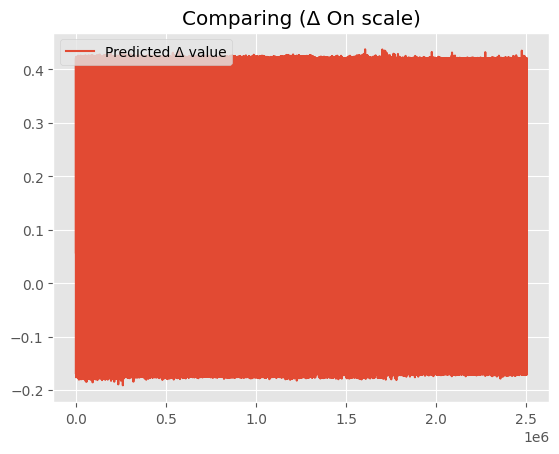

In [24]:
plt.style.use('ggplot')
# plt.plot(Y_train.flatten(), label='Real Δ value')
plt.plot(Y_1_predict.flatten(), label='Predicted Δ value')
plt.legend()
plt.title('Comparing (Δ On scale)')
plt.show()

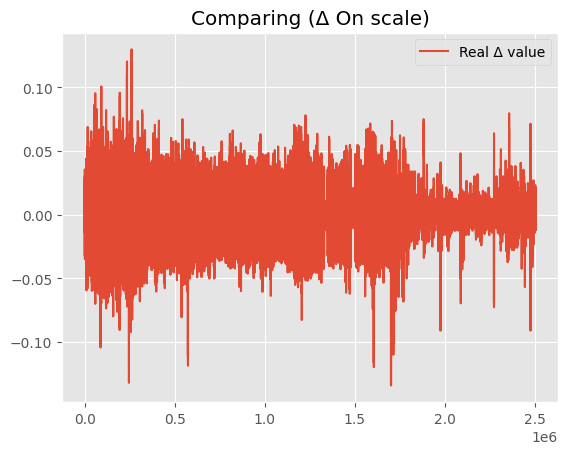

In [23]:
plt.style.use('ggplot')
plt.plot(Y_train.flatten(), label='Real Δ value')
# plt.plot(Y_1_predict.flatten(), label='Predicted Δ value')
plt.legend()
plt.title('Comparing (Δ On scale)')
plt.show()

## 4. Tập kiểm thử

In [25]:
test_interval = 60 # two months = train_interval
predict_interval = 20 # 20 days next

X_test, Y_test = [], []
data_len = len(train_data)

for i in range(0, len(test_data) - predict_interval):
    base_X = test_data[i, 0]
    j = data_len + i
    X_test.append(np.array(data[j - test_interval : j]) - base_X)
    Y_test.append(np.array(data[j : j + predict_interval]) - base_X)

X_test = np.array(X_test)
Y_test = np.array(Y_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
Y_test = np.reshape(Y_test, (Y_test.shape[0], Y_test.shape[1]))

print("Shape of X_test:", X_test.shape)  # Expected: (number_of_samples, 60, 1)
print("Shape of Y_test:", Y_test.shape)  # Expected: (number_of_samples, 20)

Shape of X_test: (80, 60, 1)
Shape of Y_test: (80, 20)


In [26]:
Y_test_predict = model.predict(X_test)
Y_test_predict.shape

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


(80, 20)

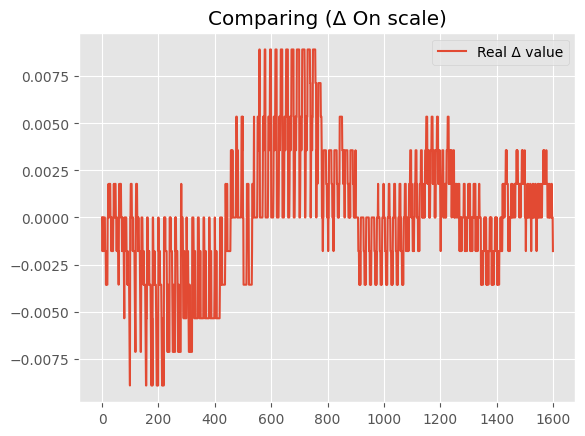

In [34]:
plt.style.use('ggplot')
plt.plot(Y_test.flatten(), label='Real Δ value')
# plt.plot(Y_test_predict.flatten(), label='Predicted Δ value')
plt.legend()
plt.title('Comparing (Δ On scale)')
plt.show()

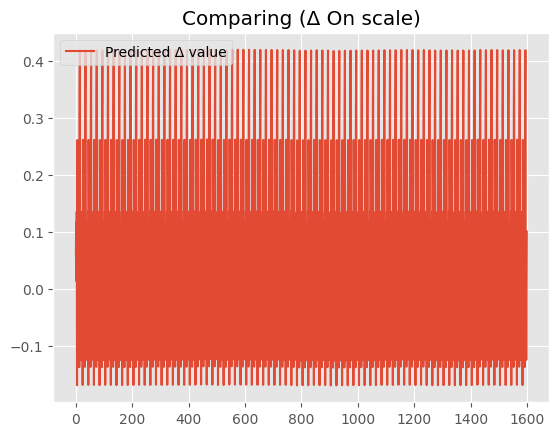

In [33]:
plt.style.use('ggplot')
# plt.plot(Y_test.flatten(), label='Real Δ value')
plt.plot(Y_test_predict.flatten(), label='Predicted Δ value')
plt.legend()
plt.title('Comparing (Δ On scale)')
plt.show()